In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.cluster import KMeans
import pickle
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

In [2]:
def logistic_regression(x, y):
    try:
        X = np.transpose([np.ones(len(x)), x])
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        coeff = 1 if model_fit.params[1] > 0 else -1
        return (model_fit.prsquared, coeff, model_fit)
    except np.linalg.LinAlgError:
        return (0, 0, None)
    except sm.tools.sm_exceptions.PerfectSeparationError:
        coeff = 1 if max(x[np.array(y, dtype=bool)]) == max(x) else -1 
        return (1, coeff, None) # Data is linearly separable

def sample_trials(alevel_idxs, n_samples):
    trial_per_alevel = 500
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * trial_per_alevel
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return np.array(random.sample(trials_to_sample, n_samples))

In [3]:
def get_data(data_dir):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 200

    s_trial = 0
    t_trial = 4000
    n_trials = t_trial - s_trial

    rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
    task_input = np.zeros((2, n_trials))
    v1v2_values = np.zeros((2, n_trials))
    wPFC_output = np.zeros((n_trials, N_OUTPUT_NEURONS, N_PFC_NEURONS))

    for i in range(s_trial, t_trial):
        with open(data_dir + "/" + str(i) + ".json") as json_file:
            data = json.load(json_file)
            idx = i - s_trial

            rPFC = np.array(data["network_rates"]["r_PFC"])
            rPFC_trials[idx,:,:] = rPFC

            trial_task_input = np.array(data["trial_data"]["input"])
            task_input[:,idx] = trial_task_input[:2]
            v1v2_values[:,idx] = trial_task_input[2:4]
            
            wPFC_output[idx,:,:] = np.array(data["network_weights"]["w_outputs"])

    return (rPFC_trials, task_input, v1v2_values, wPFC_output)

def get_trials(v1v2_values, starts_with_90):
    TRIAL_SAMPLE_SIZE = 300
    N_PFC_NEURONS = 500
    
    if starts_with_90:
        alevel_90_idxs = [0,2,4,6]
        alevel_10_idxs = [1,3,5,7]
    else:
        alevel_10_idxs = [0,2,4,6]
        alevel_90_idxs = [1,3,5,7]

    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented

    alevel_90_trials = sample_trials(alevel_90_idxs, TRIAL_SAMPLE_SIZE)
    alevel_10_trials = sample_trials(alevel_10_idxs, TRIAL_SAMPLE_SIZE)
    match_trials = alevel_90_trials
    nonmatch_trials = alevel_10_trials
    trials = np.concatenate((match_trials, nonmatch_trials))
    
    return (match_trials, nonmatch_trials, trials)

def score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials):
    N_PFC_NEURONS = 500
    N_MD_NEURONS = 2
    N_OUTPUT_NEURONS = 2
    TRIAL_TIME = 250
    
    CUE_TIME = 100
    
    cuetime_s = 50 #math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = 150 #CUE_TIME

    # NOTE: Testing outcome period, not cue
#     cuetime_s = 150
#     cuetime_t = 200
    
    cue_match = task_input[0, match_trials]
    cue_nonmatch = task_input[0, nonmatch_trials]
    
    rsquareds = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    betas = np.empty((N_PFC_NEURONS, 2))
    rsquareds[:] = np.nan
    
    for neuron_idx in range(0,N_PFC_NEURONS): 
        fr_match = np.mean(rPFC_trials[match_trials, cuetime_s:cuetime_t, neuron_idx],1)
        fr_nonmatch = np.mean(rPFC_trials[nonmatch_trials, cuetime_s:cuetime_t, neuron_idx],1)
        
        (r2_match, b_match, model_fit_match) = logistic_regression(fr_match, cue_match)
        (r2_nonmatch, b_nonmatch, model_fit_nonmatch) = logistic_regression(fr_nonmatch, cue_nonmatch)
    
        r2_match = 0 if r2_match < 0 else r2_match
        r2_nonmatch = 0 if r2_nonmatch < 0 else r2_nonmatch
            
        rsquareds[neuron_idx,:] = [r2_match, r2_nonmatch]
        betas[neuron_idx,:] = [b_match, b_nonmatch]
        
    return (rsquareds, betas)

In [4]:
def save_obj(name, obj):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/'+ name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('/om2/group/halassa/PFCMD-ali-sabrina/many_seeds/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [5]:
# RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed127_MDon"]
# RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff"]

# RUNS_MD = ["seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10"]
# RUNS_MD_NO = ["seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10"]

# RUNS_MD = ["seed127_MDon", "seed88_MDon", "seed177_MDon_10", "seed83_MDon_10"]
# RUNS_MD_NO = ["seed127_MDoff", "seed88_MDoff", "seed177_MDoff_10", "seed83_MDon_10"]

# RUNS_MD = ["seed88_MDon"]
# RUNS_MD_NO = ["seed88_MDoff"]

# for i in range(len(RUNS_MD)):
#     data_MDon = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD[i] + "/by_trial")
#     data_MDoff = get_data("/om2/group/halassa/PFCMD-ali-sabrina/" + RUNS_MD_NO[i] + "/by_trial")
#     save_obj(RUNS_MD[i], data_MDon)
#     save_obj(RUNS_MD_NO[i], data_MDoff)

In [ ]:
RUNS_MD = ["seed0_MDon", "seed42_MDon", "seed778_MDon", "seed88_MDon", "seed127_MDon", "seed12_MDon_10", "seed312_MDon_10", "seed400_MDon_10", "seed177_MDon_10", "seed83_MDon_10"]
RUNS_MD_NO = ["seed0_MDoff", "seed42_MDoff", "seed778_MDoff", "seed88_MDon", "seed127_MDoff", "seed12_MDoff_10", "seed312_MDoff_10", "seed400_MDoff_10", "seed177_MDoff_10", "seed83_MDon_10"]


scores = []
scores_noMD = []
b = []
b_noMD = []

for i in range(len(RUNS_MD)):
    starts_with_90 = i < 5
    
    (rPFC_trials, task_input, v1v2_values, wPFC_output) = load_obj(RUNS_MD[i])
    (match_trials, nonmatch_trials, trials) = get_trials(v1v2_values, starts_with_90)
    (scores_, b_) = score_cue_like(rPFC_trials, task_input, match_trials, nonmatch_trials)
        
    (rPFC_trials_noMD, task_input_noMD, v1v2_values_noMD, wPFC_output_noMD) = load_obj(RUNS_MD_NO[i])
    (match_trials_noMD, nonmatch_trials_noMD, trials_noMD) = get_trials(v1v2_values_noMD, starts_with_90)
    (scores_noMD_, b_noMD_) = score_cue_like(rPFC_trials_noMD, task_input_noMD, match_trials_noMD, nonmatch_trials_noMD)
    
    if i == 0:
        scores = scores_
        scores_noMD = scores_noMD_
        b = b_
        b_noMD = b_noMD_
    else:
        scores = np.concatenate((scores, scores_), axis=0)
        b = np.concatenate((b, b_), axis=0)
        scores_noMD = np.concatenate((scores_noMD, scores_noMD_), axis=0)
        b_noMD = np.concatenate((b_noMD, b_noMD_), axis=0)

Optimization terminated successfully.
         Current function value: 0.041361
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.154734
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.390266
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.598042
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.132898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684749
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.634874
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682418
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.116015
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167264
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1799: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:1852: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523704
         Iterations 34
Optimization terminated successfully.
         Current function value: 0.290536
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.493213
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527975
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664253
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.078153
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.437699
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.307505
         Iterations 7
Optimization terminated successfully.
         Current funct

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.048322
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543657
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.669150
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.089067
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.653236
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.127357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689913
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.452565
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680025
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.111661
         Iterations 8
Optimization ter

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.423522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689919
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.037029
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.036425
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.019643
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.046094
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.467574
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.059495
         Iterations 9
Optimization terminated successfully.
         Current fun

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.095230
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.131189
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.374937
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.043304
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109611
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679146
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.259717
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.096720
         Iterations 10
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.240523
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668915
         Iterations 44
Optimization terminated successfully.
         Current function value: 0.046208
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.391567
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.029766
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.336818
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.129188
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.518725
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.136347
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.656123
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050397
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.020208
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.148027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.527820
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.123745
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.684704
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.691337
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.184609
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.086109
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.681592
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.353076
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.338157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.662560
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.692215
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.366832
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.167298
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.153859
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691394
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689640
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.589051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009609
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110833
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.659044
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.688734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.186510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.337114
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.084566
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013110
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.262761
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.663709
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.054157
 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.263320
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105965
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.095624
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.255703
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030934
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.063341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.295313
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.556294
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.170250
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.648699

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.030549
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.691332
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.686436
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.012292
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.282002
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.689210
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.687100
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.296593
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084758
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.030255
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.228993
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.228423
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.641546
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.110688
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.614791
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.023294
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.584824
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.270271
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304449
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021063
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.431342
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.103991
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166873
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.100276
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.122091
         Iterations 16
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689684
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.668915
         Iterations 25
Optimization terminated successfully.
         Current function value: 0.692338
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.015746
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.140748
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.464820
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.109131
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.060497
         Iterations 10
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029967
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039546
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140170
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020226
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.395884
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.090429
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.152653
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679028
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.041568
         Iterations 10
         Current function value: 0.122002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.163363
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127319
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008682
         Iterations 16


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.210923
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.125331
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.687326
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.100091
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.459889
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.231427
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.615612
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.215114
         Iterations 8
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.101185
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.080539
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221185
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.333841
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.222297
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.312694
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.072265
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073361
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.689741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.033066
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.525307
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688326
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.434541
         Iterations 7
         Current function value: 0.668915
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.035754
         Iterations:

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.443849
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.327328
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.482817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.017965
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.042873
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.078164
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.079676
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.668915
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.265901
         Iterations 8
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.085201
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.272859
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.069888
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.409851
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103970
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.412231
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.686953
         Iterations 8
         Current function value: 0.048394
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689551
         Iterations 6
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.385140
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629114
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.249959
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.255105
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.051402
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.122370
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.532670
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.260690
         Iterations 8
Optimization terminat

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.669291
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.373694
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.667934
         Iterations 6
         Current function value: 0.685761
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679652
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.066347
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.291648
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.211019
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670118
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Cu

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.683750
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.161289
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.380057
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.168281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.226571
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017558
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.151601
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.109675
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.020706
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.691997


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.476995
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.072207
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.472899
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.009904
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.251595
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.274986
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.159437
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.671882
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689665
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.465032


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.116229
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.358968
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.077983
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.658391
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.211419
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.200118
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158519
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.262050
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685709
         Iterations 6
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.194700
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.390072
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051495
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.275150
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.063462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685327
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689832
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.640270
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.617137
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.090234
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139915
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.108462
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.510115
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134226
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.446872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.045193
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.099243
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.560506
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.226400
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.042712
         Iterations 13
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.477804
         Iterations 7
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.364481
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.115471
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.130681
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.196847
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.034997
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.484188
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014122
         Iterations 13
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.019424
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688787
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.421381
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.610280
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.675021
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.040898
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.687746
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.553558
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.451054
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.152833
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.066331
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.614334
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.624442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.081555
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151599
         Iterations 9
         Current function value: 0.687430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.221261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.103880
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.605946
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.029473
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.385404
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.049756
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.186812
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.384167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.304384
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.246982
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.647916
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.690193


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.060165
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.031555
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.589150
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.200897
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.346551
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.213960
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.031796
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.526349
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507332
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329826

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107565
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.661690
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.107470
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.507257
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.086640
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.380467
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.144622
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683311
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.164760
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.270233
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.251955
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013914
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.682343
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.602981
         Iterations 26
Optimization terminated successfully.
         Current function value: 0.034493
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.687440
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.677512
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.162666
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.253675
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.308870
         Iterations 7
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.241460
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688738
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.120031
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.023445
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.385755
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016343
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.316948
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.475557
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.463290
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.399270


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Iterations 11
Optimization terminated successfully.
         Current function value: 0.140598
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.141052
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.537637
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.129756
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058107
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013680
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.506156
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.131277
         Iterations 9
Optimization terminated successfully.

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.240987
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048080
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.179684
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.685404
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.219446
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.478233
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498848
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.591990
         Iterations 6
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.600382
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.689685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.642688
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.228121
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.138534
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.462171
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.441781
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.087832
         Iterations 11
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.060738
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486842
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.380484
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.669303
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.691446
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.200520
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.281472
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.673122
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.062078
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.637868
         Iterations 24
Optimization terminated successfully.
         Current function value: 0.260059
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.075126
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.607847
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.680181
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.081854
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.612885
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.077490
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.595696
         Iterations 6
         Current function value: 0.687430
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.435757
         Iterations 7
         Current function value: 0.675196
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053657
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.596897
         Iterations 29
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.599890
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.167341
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.645140
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.663201
         Iterations 7
         Current function value: inf
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648122
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.035754
         Iterations 22
Optimization terminated successfully.
         Current function value: 0.131599
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.587187
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.122010
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.128664
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494364
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649573
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.689934
         Iterations 3
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.639626
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.107167
         Iterations 9
         Current function value: 0.687430
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041948
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683747
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.366872
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.038623
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.691536
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.688902
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.118626
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.373221
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.314536
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.672836
         Iterations 5
         Current function value: 0.685761
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689758
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.048815
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.146317
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.311927
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.050867
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.576093
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685845
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.458871
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688225
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.203570
         Iterations 9
Optimization terminated successfully.
         Curren

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.543777
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.130761
         Iterations 8
         Current function value: 0.019770
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687375
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.070117
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008068
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.043422
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.570499
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.036041
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.689944
         Iterations 3
         Current function value: 0.687430
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.620696
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409550
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535828
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507040
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.137170
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.241179
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.564692
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.186814
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.043272
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.568936
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.470767


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.199206
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.035755
         Iterations 42
         Current function value: 0.671068
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.123053
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.110299
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.692347
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.048142
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.389830
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.524421
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.209304
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.122057
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.041112
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.421960
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.353215
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.236138
         Iterations 9
         Current function value: 0.035754
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686337
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.132051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.068880
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685761
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.352878
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.089829
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035830
         Iterations 15
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.095281
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.072338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.089564
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.670831
         Iterations 5
         Current function value: 0.687390
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684556
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.574970
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635469
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.029035
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.691829
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.027568
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.486279
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.578399
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000587
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.124432
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.044352
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.662383
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.686812
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.319314
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.528064
         Iterations 6
         Current function value: 0.636848
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optim

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.345867
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688827
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.411824
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.606235
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.266102
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.658713
         Iterations 6
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 55.470799
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082429
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.159819
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.367496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.166480
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.014910
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.016299
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.091935
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.171822
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.173082
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.018752
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.061562
         Iterations 11
         Current function value: 0.599215
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241592
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.138443
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.256314
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated succe

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103395
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674084
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686620
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.172095
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.024796
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.572608
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.507075
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114454
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.680765
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.040533
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.658418
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.084696
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.487165
         Iterations 7
         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017884
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.122353
         Iterations 9
         Current function value: 0.666709
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.195654
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.670593
         Iterations 5
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025090
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.633851
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689387
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.425780
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.522953
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.058153
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.432921
         Iterations 7
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.995217
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007250
         Iterations 23
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139818
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037818
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.046694
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.326386
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.428416
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000003
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.288943
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017934
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005360
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.060671
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.037332
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.132149
         Iterations 9
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.672889
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103048
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.408608
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.219936
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.061998
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.668561
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.357284
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.118208
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.562028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.413155
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692941
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.678385
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.011809
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.084591
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.175128
         Iterations 8
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.183964
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.017480
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.037350
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.090150
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.425033
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.015418
         Iterations 13
         Current function value: 0.942447
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021381
         Iterations 13


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.052511
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.447175
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.687568
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.396683
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.387671
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013900
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.185997
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.021462
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.688621
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.015809
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000074
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.067081
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.436987
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.076592
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.173675
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.646737
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.244318
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.113957
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.480671
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.327803
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.225758
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.057765
         Iterations 10
Optimization terminated successfully.
  

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014072
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026831
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.089270
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.104150
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.619398
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.117474
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.162375
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.246141
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.135449
         Iterations 9
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.528209
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016156
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.387457
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.165091
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.667157
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.688688
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.693122
         Iterations 3
         Current function value: 0.000000
         Iterations: 50
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.249974
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.155179
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.678195
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.575563
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.459866
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037535
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.011959
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.219650
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.547573
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013997
         Iterations 13
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041422
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.283161
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.305541
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.477101
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.057977
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.649486
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.116474
         Iterations 9
         Current function value: 0.382054
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006772
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.209483
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.251152
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.616684
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.051327
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.216390
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.050603
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.143606
         Iterations 9
         Current function value: 0.672813
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610152
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000015
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685063
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.358581
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.678081
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.511641
         Iterations 6
         Current function value: 0.592847
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.438877
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.012675
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.270818
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191943
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.054702
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.268366
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395988
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.259865
         Iterations 8
Optimization terminated successfully.
         Cur

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.516429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.536777
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 5.246773
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692297
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.689349
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.335319
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689242
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.032559
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.007141
         Iterations 18
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578782
         Iterations 6
         Current function value: 0.079822
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.430181
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.160705
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.048682
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.637997
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.208770
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.119111
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.078296
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.262204
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.647724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.098557
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.560807
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.007916
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.016950
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.086422
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.094698
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.293127
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693128
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.168543
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.202431
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095294
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.549570
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.006463
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000053
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687604
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.149910
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.572161
         Iterations 7
         Current function value: 0.567022
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014255
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.016499
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.684724
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.451892
         Iterations 7
         Current function value: 0.616447
         Iterations: 50
Optimization terminated 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.236439
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.365347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.390486
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.635003
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688063
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.578731
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080434
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.046345
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.193931
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.478902
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.192689
         Iterations 8
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.156886
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.027859
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.122144
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
Optimization terminated successfully.
         Current function value: 0.045984
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.006254
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.498743
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.590652
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000005
         Iterations: 50
         Current function value: 0.000454
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019586
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.142214
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.357196
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011303
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.157014
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.183489
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.547759
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.436006
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.011554
         Iterations 12
         Current function value: 0.000281
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000015
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.018828
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.543571
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.090514
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.012578
         Iterations 15
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.014918
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.310604
         Iterations 8
Optimization terminated successfully.
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.208587
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.567507
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.033695
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.192651
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.341024
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.026802
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.634611
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.110177
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.176989
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.309133
         Iterations 8
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.462793
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.621499
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.647090
         Iterations 5
         Current function value: inf
         Iterations: 50
         Current function value: 0.000135
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013653
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.600924
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.477355
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.006430
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.076700
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.389188
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.486538
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.074518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086988
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.353228
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.293599
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.229733
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.610598
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.415078
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.070548
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.111045
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.688008
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.629285
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.042351
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.686059
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.570114
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.645346
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.215330
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.617422
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.016554
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681882
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.523675
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122170
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683193
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.041549
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.583972
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692639
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.169211
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.258161
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.258884
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.229330
         Iterations 8
         Current function value: 0.606629
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680380
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.188030
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: 1.244060
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.561455
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.082606
         Iterations 9
         Current function va

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.445735
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.019751
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.253489
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681367
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.683815
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.181265
         Iterations 9
         Current function value: 0.020047
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.098309
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.191527
         Iterations 9
         Current function value: 0.683244
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052399
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.686165
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150340
         Iterations 9
         Current function value: 0.656676
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690139
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.653555
         Iterations 37
Optimization terminated successfully.
         Current function value: 0.593353
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692751
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.096117
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.515153
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.013885
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.124259
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.078037
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106031
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681466
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.373238
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.051523
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.039363
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.614312
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.646869
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131797
         I

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682922
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.193690
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.176211
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.247766
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.101856
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.100546
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.624137
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017359
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.668304
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689594
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.668585
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Curre

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078249
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.675184
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.137859
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.400404
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.689011
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.060441
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017454
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.542480
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.681426
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045403
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.195193
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.020850
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.570214
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.038925
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.689073
         Iterations 10
Optimization terminated suc

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.587590
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.034894
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.690785
         Iterations 5
         Current function value: 0.687349
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.693147
         Iterations 1
         Current function value: 0.048322
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.525001
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

Optimization terminated successfully.
         Current function value: 0.606484
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626064
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.321216
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.628103
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.083495
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.507728
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.293641
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.675378
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.350480
         Iterations 20
Optimization termin

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.151574
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.017990
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.422387
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.292266
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.588726
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150752
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.034532
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.502972
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.145505
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.019742
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.098333
         Iterations 10
Optimization terminated successfully.
         Current func

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.166851
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.131639
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.679917
         Iterations 4
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.078671
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.416803
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.531477
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.648771
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.083634
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.144939
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.079023
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.684482
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.659205
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.494855
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.060788
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.010862
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.054904
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.687261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.635161
         Iterations 5
Optimization

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.077683
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.609383
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.075473
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.101682
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.086839
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.374320
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.231718
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030826
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.411981
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.071374
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.254972
         Iterations 8
Optimization t

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.341053
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.207088
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.073955
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.390495
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683899
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.608466
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033773
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060203
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.014712
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.034463
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.430534
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.071133
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.065195
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013696
         Iterations 13
         Current function value: 0.660080
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687814
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.428946
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.297731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007665
         Iterations 18
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.095619
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011216
         Iterations 14
Optimiza

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.656697
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.114668
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.105243
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.548691
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.565985
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.182651
         Iterations 8
Optimization terminated successfully

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685185
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.217670
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.021022
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.079933
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.346461
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.336100
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.329162
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.016445
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.048539
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.675007
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.220012
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.678209
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.533646
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.166922
         Iterations 9
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.058142
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.059834
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.024625
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.151047
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.070149
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.331628
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.186670
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successful

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.069353
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.291817
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674628
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.377215
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.606498
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.143950
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.590713
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.041815
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.499121
         Iterations 36
Optimization terminated successfully.
         Current function value: 0.042894
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.325938
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.620211
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.681616
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.029772
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.007721
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.024289
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.099739
         Iterations 12
Optimizati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.249255
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050138
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.641077
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.182958
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.052782
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.034701
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.685530
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.682704
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
       

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.231382
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008475
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.044325
         Iterations 12


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.665321
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.071064
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.158974
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.417132
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.272898
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682862
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.683155
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.567658
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.125767
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.062214
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.273799
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.172518
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization term

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000003
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.103469
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.151583
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.119269
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.067534
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686768
         Iterations 19
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.010205
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.057598
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.312575
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095214
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.011092
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.670855
         Iterations 5
Optimization terminated successfully.
         Curr

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.175357
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134027
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.180051
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.438164
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022663
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.064064
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.076293
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.449522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.053595
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.03803

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.559575
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.050470
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.571241
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.013929
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.627065
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.435647
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.085405
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684049
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.638045
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.321044
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.007565
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.139335
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686662
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.042008
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.109123
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.038038
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.673261
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634563
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.041351
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         C

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.047984
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.641267
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.258015
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.677558
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.657973
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.256646
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.549993
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.610810
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.364875
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.056056
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.621890
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.021964
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.053343
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.033313
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.050992
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.030717
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.109941
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.224311
         Iterations 9


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.029776
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.075986
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.181038
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.221874
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.411953
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377473
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.238882
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.190733
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.602713
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization te

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.246084
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683993
         Iterations 20
Optimization terminated successfully.
         Current function value: 0.666296
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.684472
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.389670
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.102440
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071416
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.098502
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.139341
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.075635
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.078643
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640496
         Iterations 6
         Current function val

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.167804
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.105354
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.545805
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.072311
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.475189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.323567
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683167
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.010753
         Iterations 18
Optimization terminated successfully.
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.283821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.152146
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.008093
         Iterations 14
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.139943
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.512221
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.290078
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040865
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.015021
         Iterati

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.176065
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.205176
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.565346
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.457442
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.535032
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.347698
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.501133
         Iterations 7
Optimization terminated successf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.181917
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.063208
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038873
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.620872
         Iterations 6
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.277803
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.319022
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.538025
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.025807
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.449302
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.450925
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.641756
         Iterations 6
         Current function value: 0.129276
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272748
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.208299
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.112286
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.166936
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.123186
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.245387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.127075
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.274854
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.198281
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.102808
         Iteratio

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.036390
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.175059
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.114209
         Iterations 15
         Current function value: 0.682704
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.024341
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.378261
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.682362
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.040444
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.680515
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.049565
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.038009
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.128879
         Iterations 8
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.641151
         Iterations: 50
         Current function value: 0.048250
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.054411
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.062313
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.364782
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.409689
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.688778
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.343052
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010687
         Iterations 13
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.299203
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.541134
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.048417
         Iterations 15
Optimization terminated s

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.016843
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.114973
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.136543
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686747
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.024883
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.671996
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.685407
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.677294
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.185779
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.009122
         Iterations 16
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.419596
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.126075
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.173029
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039061
         Iterations 11
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.593813
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.410874
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.037854
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.109021
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.084940
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.036412
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
   

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.682356
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.249234
         Iterations 8
         Current function value: 0.639076
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684743
         Iterations 21
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.135373
         Iterations 8
         Current function value: 0.636173
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.214697
         Iterations 9
         Current function value: 0.048250
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.223245
         Iterations 8
         Current function value: 0.359355
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.285029
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000001
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.039551
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.681259
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.228900
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.148788
         Iterations 8
         Current function value: 0.593050
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.066901
         Iterations 10
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.150976
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.684731
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.212908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.688168
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.614287
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.272526
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.656611
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.048600
         Iterations 15
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.670873
         Iterations 5
         Current function value: 0.682704
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.022350
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.449652
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.501923
         Iterations 7


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 3.472201
         Iterations: 50
         Current function value: 0.696332
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.106455
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: 0.020346
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642322
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.679731
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.267050
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.600469
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.212364
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.018494
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.532128
         Iterations 7
         Current function value

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.688685
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.684622
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.176591
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.107807
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.427727
         Iterations 12
         Current function value: inf
         Iterations: 50
         Current function value: 0.686768
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.048250
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.093932
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.547182
         Iterations 8
         Current function value: 0.000001
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.127568
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.681981
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.682467
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.686602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.123834
         Iterations 38
Optimization terminated successfully.
         Current function value: 0.022351
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000001
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.586106
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated succ

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.679247
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.144905
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.597345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.578562
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685536
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.683542
         Iterations 4


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685358
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.189235
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.520638
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.431706
         Iterations 19
         Current function value: 0.184764
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-p

         Current function value: 0.682704
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.048281
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.659787
         Iterations: 50
         Current function value: 0.034865
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.085227
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.100457
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.665101
         Iterations 7
         Current function value: 0.000008
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.032751
         Iterations 14
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.437176
         Iterations 7

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.410949
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.073784
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.688785
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.685930
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.326537
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.129376
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.071368
         Iterations 11
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.077916
         Iterations 9
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000956
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127911
         Iterations 10

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008893
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.477365
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.063490
         Iterations 10
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.060546
         Iterations: 50
         Current function value: 2.027721
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.066762
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.645627
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.028819
         Iterations 11
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.080477
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.359164
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.025183
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.082295
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.033617
         Iterations 11
         Current function value: 0.677665
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.060345
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.155027
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.085770
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.170525
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.445457
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.095519
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.040515
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.043141
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.047192
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.649763
         Iterations 7
         Current 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.493275
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616156
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.609077
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.640508
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.638450
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.677063
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.670434
         Iterations 5
         Current function value: 0.685470
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.187510
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.045756
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.676764
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642370
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.013218
         Iterations 13
         Current function value: 0.473956
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.011494
         Iterations 14


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.085596
         Iterations 11
         Current function value: 0.667229
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.518124
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.094749
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.297328
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013210
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682908
         Iterations 7
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.395080
         Iterations 8
         Current function value: 0.857554
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.275490
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.099916
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.653636
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000011
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.005922
         Iterations 21
Optimization terminated successfully.
         Current function value: 0.539418
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.275593
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.029086
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.122748
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.134516
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.248219
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.301808
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.006395
         Iterations 19
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.025080
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.015256
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.149908
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.098419
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.413539
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.012337
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.272616
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.019249
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.487911
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.056997
         Iterations 12
         

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.261553
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.337016
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.324254
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.680186
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673141
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.338989
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.390338
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.626205
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.077176
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
Optimization terminated successfully.
         Current f

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.134524
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.684694
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050894
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.442978
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.667310
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.293411
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.652583
         Iterations 5
Optimization terminated succes

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 6.061127
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.381586
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.567777
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.667074
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.631252
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.484046
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.028928
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.643726
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.050828
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.047474
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.540714
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.683483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.231228
         Iterations 8


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687921
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.639740
         Iterations 5
         Current function value: 0.301248
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.051919
         Iterations 11


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.127876
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.156209
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.500931
         Iterations 8

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.664799
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.644549
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.246554
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.040969
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.594246
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.190799
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.008652
         Iterations 19
Optimization terminated successfully.
         Current function value: 0.619413
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.013996
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.587361
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.073714
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.436636
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.205065
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.680815
         Iterations 4
         Current function value: 0.679930
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.674608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.068705
         Iterations 13
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.642546
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.375749
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.033607
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.006038
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.099344
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.081519
         Iterations 10


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.164151
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.036039
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.671130
         Iterations 6
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.585487
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.392303
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.062885
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.234138
         Iterations 8
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.030867
         Ite

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.183267
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.220481
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.106160
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.241708
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.251434
         Iterations 8
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.026538
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.674266
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.430242
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.685929
         Iterations 5
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.283738
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.013538
         Iterations 14
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000138
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687793
         Iterations 4
         Current function value: 0.000007
         Iterations: 50
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.389065
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.204731
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.035188
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.304554
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.008005
         Iterations 17


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.035086
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.050298
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.235072
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.040810
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.026579
         Iterations 12
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.687502
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.110656
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.438936
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.579740
         Iterations 6
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.554986
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.245499
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.630979
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.081299
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.669812
         Iterations 5
         Current function value: 0.000000
         Iterations: 50


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.045602
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.641365
         Iterations 5
         Current function value: 0.686141
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.668348
         Iterations 17
         Current function value: 0.000218
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.375109
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.009948
         Iterations 15
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfull

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.012382
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.096845
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.513469
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.023960
         Iterations 12
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.686430
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681254
         Iterations 5


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.014454
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.174814
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.055785
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.682899
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.624144
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.025874
         Iterations 11
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.495228
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.163628
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.557550
         Iterations 6


/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Optimization terminated successfully.
         Current function value: 0.165450
         Iterations 9
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.368345
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.683315
         Iterations 4
         Current function value: inf
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.008085
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.444225
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.022276
         Iterations 12
         Current function value: 0.000000
         Iterations: 50
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
def plot_bars(ax, D, style="number"):
    w = 0.3
    x = np.arange(len(D.keys()))
            
    means1 = []
    means2 = []
    std_errs1 = []
    std_errs2 = []
    
    d1s = []
    d2s = []
    for key in D:
        if style == "number":
            d1 = D[key][0]
            d2 = D[key][1]
        elif style == "perc-pfc":
            d1 = [x / N_PFC_NEURONS for x in D[key][0]]
            d2 = [x / N_PFC_NEURONS for x in D[key][1]]
        elif style == "perc-cue":
            d1 = []
            d2 = []
            for i in range(len(D[key][0])):
                x1 = D[key][0][i] / np.sum([D[k][0][i] for k in D.keys()])
                d1.append(x1)
                x2 = D[key][1][i] / np.sum([D[k][1][i] for k in D.keys()])
                d2.append(x2)
                
        means1.append(np.mean(d1))
        means2.append(np.mean(d2))
        std_errs1.append(np.std(d1) / math.sqrt(len(d1)))
        std_errs2.append(np.std(d2) / math.sqrt(len(d2)))
        d1s.append(d1)
        d2s.append(d2)

    ax.bar(x-w/2, means1, width=w, label="max")
    ax.errorbar(x-w/2, means1, std_errs1, color="k", capsize=2, zorder=20)
    ax.bar(x+w/2, means2, width=w, label="second max")
    ax.errorbar(x+w/2, means2, std_errs2, color="k", capsize=2, zorder=20)
    for i in range(len(d1s)):
        ax.scatter(np.ones(len(d1s[i]))*i-w/2, d1s[i], color="grey", marker="x", s=10, zorder=10)
        ax.scatter(np.ones(len(d2s[i]))*i+w/2, d2s[i], color="grey", marker="x", s=10, zorder=10)
    plt.xticks(x, D.keys(), rotation = 25)
    if style == "perc-pfc" or style == "perc-cue":
        ax.yaxis.set_major_formatter(PercentFormatter(1))



In [ ]:
def plot_kmeans(ax, X):
    model = KMeans(n_clusters=5)
    model.fit(X)
    yhat = model.predict(X)
    clusters = np.unique(yhat)
    for cluster in clusters:
        row_ix = np.where(yhat == cluster)
        ax.scatter(X[row_ix, 0], X[row_ix, 1], marker=".")

fig = plt.figure(figsize=(15,12))
N_PFC_NEURONS = 500
hist_weights = np.ones(N_PFC_NEURONS * len(RUNS_MD)) / (N_PFC_NEURONS * len(RUNS_MD))

ax1 = fig.add_subplot(2,3,1)
ax1.scatter(scores[:,0],scores[:,1], marker=".")
ax1.set_xlabel("Cue-like in match")
ax1.set_ylabel("Cue-like in non-match")
ax1.set_title("Scores with MD")

ax2 = fig.add_subplot(2,3,4)
ax2.hist(scores[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax2.hist(scores[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax2.legend()
ax2.yaxis.set_major_formatter(PercentFormatter(1))
ax2.set_title("Cue-like per context with MD")
ax2.set_xlabel("Logistic regression R^2")
ax2.set_ylabel("Num neurons")
ax2.set_ylim((0,0.6))

ax3 = fig.add_subplot(2,3,2)
ax3.scatter(scores_noMD[:,0],scores_noMD[:,1], marker=".")
ax3.set_xlabel("Cue-like in match")
ax3.set_ylabel("Cue-like in non-match")
ax3.set_title("Scores no MD")

ax4 = fig.add_subplot(2,3,5)
w1 = np.ones(len(scores_noMD[:,0])) / len(scores_noMD[:,0])
ax4.hist(scores_noMD[:,0], bins=20, fc=(0, 0, 1, 0.5), weights=hist_weights, label="Cue-like in match")
ax4.hist(scores_noMD[:,1], bins=20, fc=(1, 0, 0, 0.5), weights=hist_weights, label="Cue-like in non-match")
ax4.legend()
ax4.yaxis.set_major_formatter(PercentFormatter(1))
ax4.set_title("Cue-like per context no MD")
ax4.set_xlabel("Logistic regression R^2")
ax4.set_ylabel("Num neurons")
ax4.set_ylim((0,0.6))

ax5 = fig.add_subplot(2,3,3)
ax5.hist(np.add(scores[:,0], scores[:,1]), bins=20, fc=(0, 0, 1, 0.5), label="Cue-like combined MD")
ax5.hist(np.add(scores_noMD[:,0], scores_noMD[:,1]), bins=20, fc=(0, 1, 0, 0.5), label="Cue-like combined no MD")
ax5.legend()
ax5.set_title("match scores + non-match scores")
ax5.set_xlabel("summed score")
ax5.set_ylabel("num neurons")

ax6 = fig.add_subplot(2,3,6)

def get_nums(s):
    num_cue1 = []
    num_cue2 = []
    num_cue = []
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        num_cue1.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]))
        num_cue2.append(len(np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]))
        num_cue.append(len(np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]))
    return (num_cue1, num_cue2, num_cue)

(num_cue1_MD, num_cue2_MD, num_cue_MD) = get_nums(scores)
(num_cue1_noMD, num_cue2_noMD, num_cue_noMD) = get_nums(scores_noMD)
D = {}
D["match_cue-like"] = (num_cue1_MD, num_cue1_noMD)
D["nonmatch cue-like"] = (num_cue2_MD, num_cue2_noMD)
D["match and nonmatch cue-like"] = (num_cue_MD, num_cue_noMD)
plot_bars(ax6, D, "perc-cue")
ax6.set_ylabel("num neurons")
ax6.set_title("Numb neurons (thresholds 0.9 and 0.1)")
plt.show()


In [ ]:
N_PFC_NEURONS = 500
def get_nums7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]

        match_cue1_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == 1)[0]]))
        match_cue2_neurons.append(len(match_neurons[np.where(b[match_neurons,0] == -1)[0]]))
        nomatch_cue1_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]))
        nonmatch_cue2_neurons.append(len(nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]))
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.append(len(cuelike_cue1_neurons_))
        cuelike_cue2_neurons.append(len(cuelike_cue2_neurons_))        
        cuelike_mixed_neurons.append(len(np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))))
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons)
                                     
                        
(num_match_cue1_neurons, num_match_cue2_neurons, num_nomatch_cue1_neurons, num_nonmatch_cue2_neurons, num_cuelike_cue1_neurons, num_cuelike_cue2_neurons, num_cuelike_mixed_neurons) = get_nums7(scores, b)
(num_match_cue1_neurons_noMD, num_match_cue2_neurons_noMD, num_nomatch_cue1_neurons_noMD, num_nonmatch_cue2_neurons_noMD, num_cuelike_cue1_neurons_noMD, num_cuelike_cue2_neurons_noMD, num_cuelike_mixed_neurons_noMD) = get_nums7(scores_noMD, b_noMD)
D = {}
D["match cue1"] = (num_match_cue1_neurons, num_match_cue1_neurons_noMD)
D["match cue2"] = (num_match_cue2_neurons, num_match_cue2_neurons_noMD)
D["nonmatch cue1"] = (num_nomatch_cue1_neurons, num_nomatch_cue1_neurons_noMD)
D["nonmatch cue2"] = (num_nonmatch_cue2_neurons, num_nonmatch_cue2_neurons_noMD)
D["both cue1"] = (num_cuelike_cue1_neurons, num_cuelike_cue1_neurons_noMD)
D["both cue2"] = (num_cuelike_cue2_neurons, num_cuelike_cue2_neurons_noMD)
D["both mixed"] = (num_cuelike_mixed_neurons, num_cuelike_mixed_neurons_noMD)                       
plot_bars(plt.gca(), D, "number")
plt.ylabel("num neurons %")
plt.title("Num neurons (thresholds 0.9 and 0.1)")
                                     

In [ ]:
fig = plt.figure(figsize=(15,5))

H1, xedges, yedges = np.histogram2d(scores[:,0], scores[:,1], bins=10)
H2, _, _ = np.histogram2d(scores_noMD[:,0], scores_noMD[:,1], bins=10)
H3 = np.subtract(H1, H2)

vmax = max(np.max(H1),np.max(H2))
vmin = np.min(H3)

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(H1, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax1.set_title("R^2 scores with MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(H2, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax2.set_title("R^2 scores no MD")
ax1.set_xlabel("Num cue-like in match")
ax1.set_ylabel("Num cue-like in non-match")

ax3 = fig.add_subplot(1,3,3)
im = ax3.imshow(H3, vmin=vmin, vmax=vmax, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax3.set_title("R^2 scores difference")
ax3.set_xlabel("Num cue-like in match")
ax3.set_ylabel("Num cue-like in non-match")

fig.colorbar(im)

plt.show()

In [ ]:
N_PFC_NEURONS = 500

def get_idxs7(s,b):
    match_cue1_neurons = []
    match_cue2_neurons = []
    nomatch_cue1_neurons = []
    nonmatch_cue2_neurons = []
    cuelike_cue1_neurons = []
    cuelike_cue2_neurons = []
    cuelike_mixed_neurons = []
        
    for i in range(len(RUNS_MD)):
        i_low = i * N_PFC_NEURONS
        i_high = (i+1) * N_PFC_NEURONS
        match_neurons    = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] < 0.1))[0]
        nonmatch_neurons = np.where(np.logical_and(s[i_low:i_high,1] > 0.9, s[i_low:i_high,0] < 0.1))[0]
        cuelike_neurons  = np.where(np.logical_and(s[i_low:i_high,0] > 0.9, s[i_low:i_high,1] > 0.9))[0]
        
        match_cue1_neurons.extend([match_neurons[np.where(b[match_neurons,0] == 1)[0]]])
        match_cue2_neurons.extend([match_neurons[np.where(b[match_neurons,0] == -1)[0]]])
        nomatch_cue1_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == 1)[0]]])
        nonmatch_cue2_neurons.extend([nonmatch_neurons[np.where(b[nonmatch_neurons,1] == -1)[0]]])
        
        cuelike_cue1_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == 1, b[cuelike_neurons,1] == 1))[0]]
        cuelike_cue2_neurons_ = cuelike_neurons[np.where(np.logical_and(b[cuelike_neurons,0] == -1, b[cuelike_neurons,1] == -1))[0]]
        cuelike_cue1_neurons.extend([cuelike_cue1_neurons_])
        cuelike_cue2_neurons.extend([cuelike_cue2_neurons_])     
        cuelike_mixed_neurons.extend([np.setdiff1d(cuelike_neurons, np.concatenate((cuelike_cue1_neurons_, cuelike_cue2_neurons_)))])
        
    return (match_cue1_neurons, match_cue2_neurons, nomatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) 

(match_cue1_neurons, match_cue2_neurons, nonmatch_cue1_neurons, nonmatch_cue2_neurons, cuelike_cue1_neurons, cuelike_cue2_neurons, cuelike_mixed_neurons) = get_idxs7(scores, b)
(match_cue1_neurons_noMD, match_cue2_neurons_noMD, nonmatch_cue1_neurons_noMD, nonmatch_cue2_neurons_noMD, cuelike_cue1_neurons_noMD, cuelike_cue2_neurons_noMD, cuelike_mixed_neurons_noMD) = get_idxs7(scores_noMD, b_noMD)


(3000, 2)
(4000, 72)


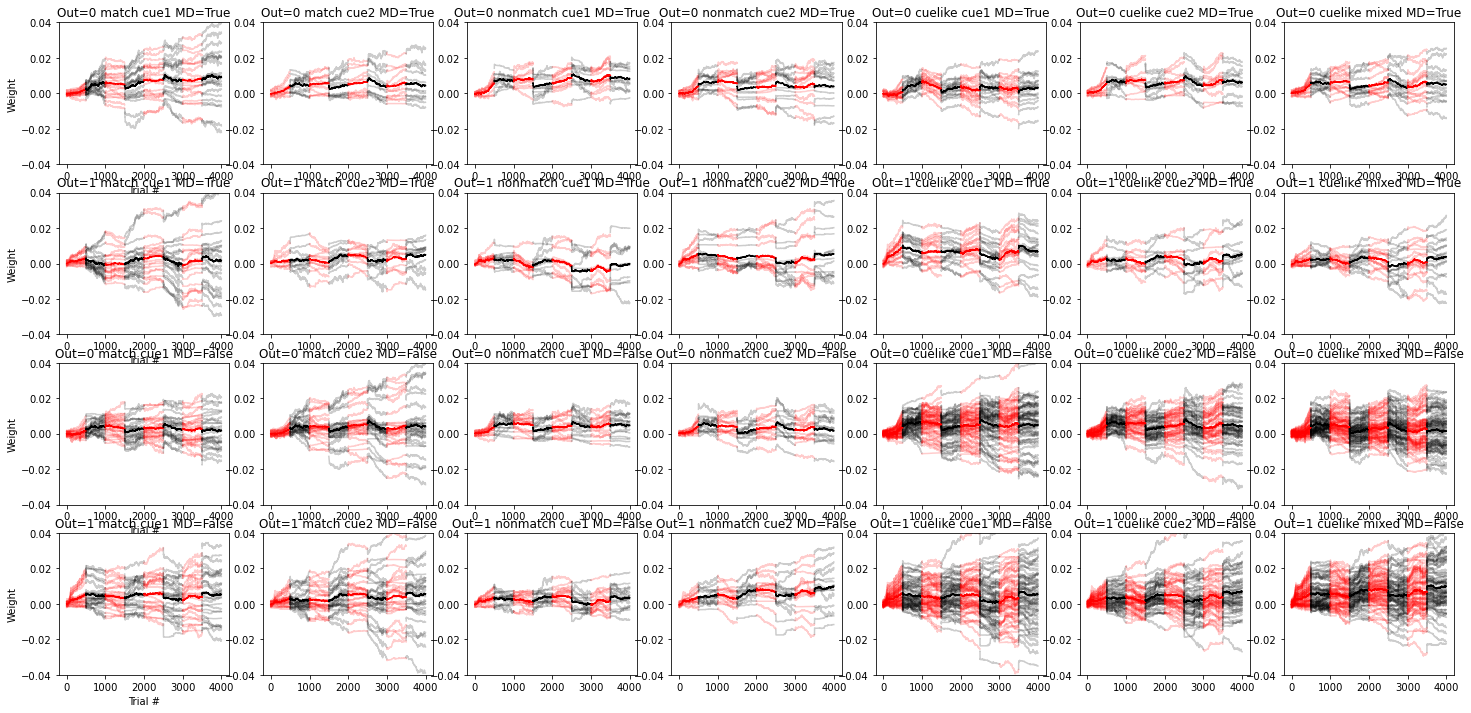

In [13]:
# IGNORE THIS CELL -- I FORGET WHAT'S GOING ON HERE

def plot_weights(run_idx, scores, wPFC_output, scores_noMD, wPFC_output_noMD):
    cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
    cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
    cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
    cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
    cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
    cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

    x = np.arange(0,4000)
    wPFC_out0_all = wPFC_output[match_trials,0,:]
    wPFC_out1_all = wPFC_output[match_trials,1,:]
    wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
    wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

    m0 = np.mean(wPFC_out0_all,1)
    m1 = np.mean(wPFC_out1_all,1)
    e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
    e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

    m0_noMD = np.mean(wPFC_out0_all_noMD,1)
    m1_noMD = np.mean(wPFC_out1_all_noMD,1)
    e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
    e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

    wPFC_out0_match_cue1_MD = wPFC_output[:,0,match_cue1_neurons[run_idx]]
    wPFC_out0_match_cue2_MD = wPFC_output[:,0,match_cue2_neurons[run_idx]]
    wPFC_out0_nonmatch_cue1_MD = wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]]
    wPFC_out0_nonmatch_cue2_MD = wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_cue1_MD = wPFC_output[:,0,cuelike_cue1_neurons[run_idx]]
    wPFC_out0_cuelike_cue2_MD = wPFC_output[:,0,cuelike_cue2_neurons[run_idx]]
    wPFC_out0_cuelike_mixed_MD = wPFC_output[:,0,cuelike_mixed_neurons[run_idx]]

    wPFC_out1_match_cue1_MD = wPFC_output[:,1,match_cue1_neurons[run_idx]]
    wPFC_out1_match_cue2_MD = wPFC_output[:,1,match_cue2_neurons[run_idx]]
    wPFC_out1_nonmatch_cue1_MD = wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]]
    wPFC_out1_nonmatch_cue2_MD = wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_cue1_MD = wPFC_output[:,1,cuelike_cue1_neurons[run_idx]]
    wPFC_out1_cuelike_cue2_MD = wPFC_output[:,1,cuelike_cue2_neurons[run_idx]]
    wPFC_out1_cuelike_mixed_MD = wPFC_output[:,1,cuelike_mixed_neurons[run_idx]]

    wPFC_out0_match_cue1_noMD = wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]]
    wPFC_out0_match_cue2_noMD = wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue1_noMD = wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out0_nonmatch_cue2_noMD = wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue1_noMD = wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_cue2_noMD = wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out0_cuelike_mixed_noMD = wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]]

    wPFC_out1_match_cue1_noMD = wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]]
    wPFC_out1_match_cue2_noMD = wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue1_noMD = wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]]
    wPFC_out1_nonmatch_cue2_noMD = wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue1_noMD = wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_cue2_noMD = wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]]
    wPFC_out1_cuelike_mixed_noMD = wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]]

    def plt_trials(ax, w):
        if w.shape[1] == 0:
            return

        match_blocks = [1,3,5,7]
        nmatch_blocks = [0,2,4,6]

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)

        for block in range(0,8):
            c = 'k' if block in match_blocks else 'r'
            s = block * 500
            t = block * 500 + 500
            m = np.mean(w[s:t,:],1)
            e = np.std(w[s:t,:],1)        
            ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
#             ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)

    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    plt_trials(ax1,wPFC_out0_match_cue1_MD)
    ax1.set_ylim((-0.04,0.04))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    plt_trials(ax2,wPFC_out0_match_cue2_MD)
    ax2.set_ylim((-0.04,0.04))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)
    ax3.set_ylim((-0.04,0.04))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)
    ax4.set_ylim((-0.04,0.04))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)
    ax5.set_ylim((-0.04,0.04))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)
    ax6.set_ylim((-0.04,0.04))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)
    ax7.set_ylim((-0.04,0.04))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    plt_trials(ax8,wPFC_out1_match_cue1_MD)
    ax8.set_ylim((-0.04,0.04))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    plt_trials(ax9,wPFC_out1_match_cue2_MD)
    ax9.set_ylim((-0.04,0.04))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)
    ax10.set_ylim((-0.04,0.04))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)
    ax11.set_ylim((-0.04,0.04))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)
    ax12.set_ylim((-0.04,0.04))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)
    ax13.set_ylim((-0.04,0.04))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)
    ax14.set_ylim((-0.04,0.04))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    plt_trials(ax15,wPFC_out0_match_cue1_noMD)
    ax15.set_ylim((-0.04,0.04))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    plt_trials(ax16,wPFC_out0_match_cue2_noMD)
    ax16.set_ylim((-0.04,0.04))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)
    ax17.set_ylim((-0.04,0.04))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)
    ax18.set_ylim((-0.04,0.04))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)
    ax19.set_ylim((-0.04,0.04))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)
    ax20.set_ylim((-0.04,0.04))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)
    ax21.set_ylim((-0.04,0.04))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    plt_trials(ax22,wPFC_out1_match_cue1_noMD)
    ax22.set_ylim((-0.04,0.04))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    plt_trials(ax23,wPFC_out1_match_cue2_noMD)
    ax23.set_ylim((-0.04,0.04))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)
    ax24.set_ylim((-0.04,0.04))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)
    ax25.set_ylim((-0.04,0.04))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)
    ax26.set_ylim((-0.04,0.04))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)
    ax27.set_ylim((-0.04,0.04))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)
    ax28.set_ylim((-0.04,0.04))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    print(wPFC_out1_cuelike_mixed_noMD.shape)

    plt.show()

    
(_, _, _, wPFC_output) = load_obj(RUNS_MD[5])
(_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[5])
plot_weights(5, scores[2500:3000], wPFC_output, scores_noMD[2500:3000], wPFC_output_noMD)

/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/om2/user/sdrammis/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


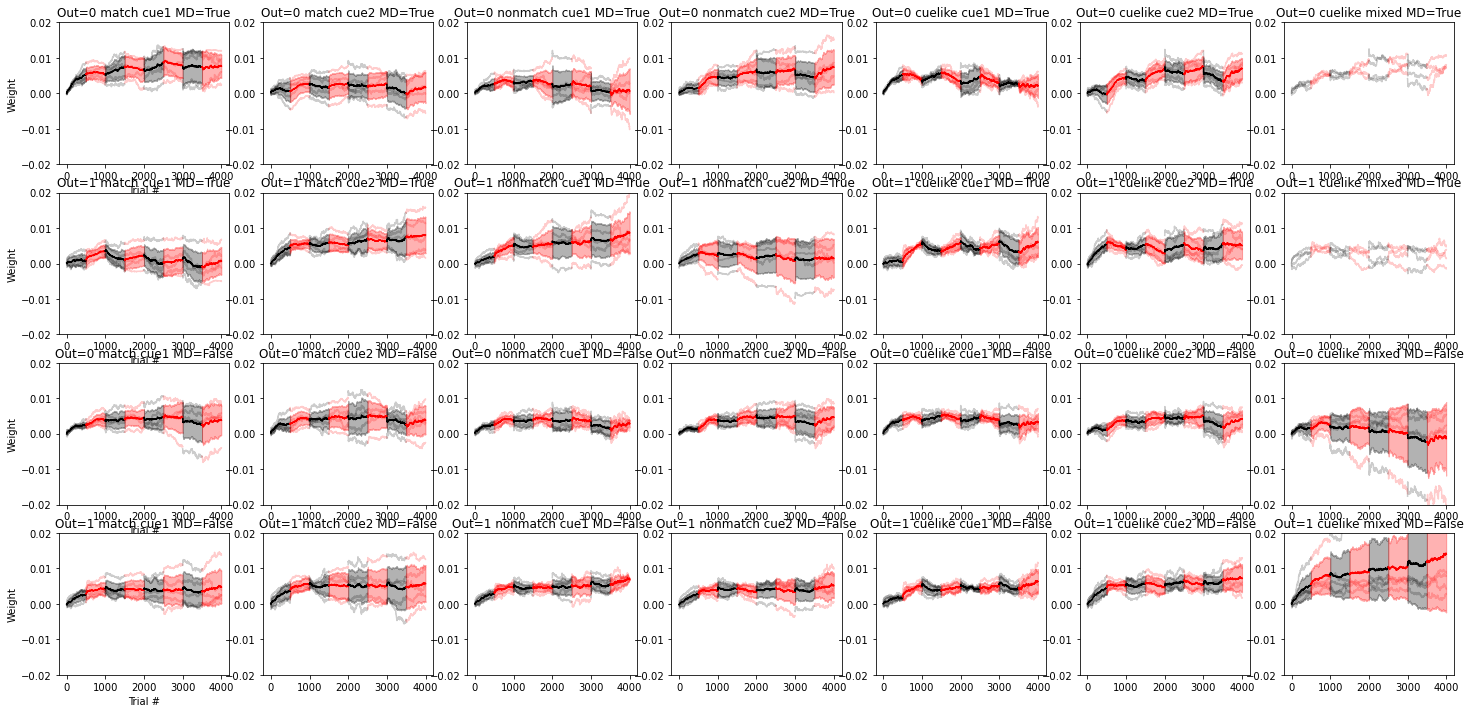

In [27]:
def plt_trials(ax, w, starts_with_match=True):
    if w.shape[1] == 0:
        return

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        ax.plot(np.arange(s,t), w[s:t,:], c, alpha=0.2)
        c = 'k' if c == 'r' else 'r'

    c = 'k' if starts_with_match else 'r'
    for block in range(0,8):
        s = block * 500
        t = block * 500 + 500
        m = np.mean(w[s:t,:],1)
        e = np.std(w[s:t,:],1)        
        ax.plot(np.arange(s,t), np.mean(w[s:t,:], 1), c)
        ax.fill_between(np.arange(s,t), m-e, m+e, color=c, alpha=0.3)
        c = 'k' if c == 'r' else 'r'

def plot_weights(scores_, scores_noMD_):
    fig = plt.figure(figsize=(25,12))

    ax1 = fig.add_subplot(4,7,1)
    ax1.set_ylim((-0.02,0.02))
    ax1.set_title("Out=0 match cue1 MD=True")
    ax1.set_xlabel("Trial #")
    ax1.set_ylabel("Weight")

    ax2 = fig.add_subplot(4,7,2)
    ax2.set_ylim((-0.02,0.02))
    ax2.set_title("Out=0 match cue2 MD=True")

    ax3 = fig.add_subplot(4,7,3)
    ax3.set_ylim((-0.02,0.02))
    ax3.set_title("Out=0 nonmatch cue1 MD=True")

    ax4 = fig.add_subplot(4,7,4)
    ax4.set_ylim((-0.02,0.02))
    ax4.set_title("Out=0 nonmatch cue2 MD=True")

    ax5 = fig.add_subplot(4,7,5)
    ax5.set_ylim((-0.02,0.02))
    ax5.set_title("Out=0 cuelike cue1 MD=True")

    ax6 = fig.add_subplot(4,7,6)
    ax6.set_ylim((-0.02,0.02))
    ax6.set_title("Out=0 cuelike cue2 MD=True")

    ax7 = fig.add_subplot(4,7,7)
    ax7.set_ylim((-0.02,0.02))
    ax7.set_title("Out=0 cuelike mixed MD=True")

    ax8 = fig.add_subplot(4,7,8)
    ax8.set_ylim((-0.02,0.02))
    ax8.set_title("Out=1 match cue1 MD=True")
    ax8.set_xlabel("Trial #")
    ax8.set_ylabel("Weight")

    ax9 = fig.add_subplot(4,7,9)
    ax9.set_ylim((-0.02,0.02))
    ax9.set_title("Out=1 match cue2 MD=True")

    ax10 = fig.add_subplot(4,7,10)
    ax10.set_ylim((-0.02,0.02))
    ax10.set_title("Out=1 nonmatch cue1 MD=True")

    ax11 = fig.add_subplot(4,7,11)
    ax11.set_ylim((-0.02,0.02))
    ax11.set_title("Out=1 nonmatch cue2 MD=True")

    ax12 = fig.add_subplot(4,7,12)
    ax12.set_ylim((-0.02,0.02))
    ax12.set_title("Out=1 cuelike cue1 MD=True")

    ax13 = fig.add_subplot(4,7,13)
    ax13.set_ylim((-0.02,0.02))
    ax13.set_title("Out=1 cuelike cue2 MD=True")

    ax14 = fig.add_subplot(4,7,14)
    ax14.set_ylim((-0.02,0.02))
    ax14.set_title("Out=1 cuelike mixed MD=True")

    ax15 = fig.add_subplot(4,7,15)
    ax15.set_ylim((-0.02,0.02))
    ax15.set_title("Out=0 match cue1 MD=False")
    ax15.set_xlabel("Trial #")
    ax15.set_ylabel("Weight")

    ax16 = fig.add_subplot(4,7,16)
    ax16.set_ylim((-0.02,0.02))
    ax16.set_title("Out=0 match cue2 MD=False")

    ax17 = fig.add_subplot(4,7,17)
    ax17.set_ylim((-0.02,0.02))
    ax17.set_title("Out=0 nonmatch cue1 MD=False")

    ax18 = fig.add_subplot(4,7,18)
    ax18.set_ylim((-0.02,0.02))
    ax18.set_title("Out=0 nonmatch cue2 MD=False")

    ax19 = fig.add_subplot(4,7,19)
    ax19.set_ylim((-0.02,0.02))
    ax19.set_title("Out=0 cuelike cue1 MD=False")

    ax20 = fig.add_subplot(4,7,20)
    ax20.set_ylim((-0.02,0.02))
    ax20.set_title("Out=0 cuelike cue2 MD=False")

    ax21 = fig.add_subplot(4,7,21)
    ax21.set_ylim((-0.02,0.02))
    ax21.set_title("Out=0 cuelike mixed MD=False")

    ax22 = fig.add_subplot(4,7,22)
    ax22.set_ylim((-0.02,0.02))
    ax22.set_title("Out=1 match cue1 MD=False")
    ax22.set_xlabel("Trial #")
    ax22.set_ylabel("Weight")

    ax23 = fig.add_subplot(4,7,23)
    ax23.set_ylim((-0.02,0.02))
    ax23.set_title("Out=1 match cue2 MD=False")

    ax24 = fig.add_subplot(4,7,24)
    ax24.set_ylim((-0.02,0.02))
    ax24.set_title("Out=1 nonmatch cue1 MD=False")

    ax25 = fig.add_subplot(4,7,25)
    ax25.set_ylim((-0.02,0.02))
    ax25.set_title("Out=1 nonmatch cue2 MD=False")

    ax26 = fig.add_subplot(4,7,26)
    ax26.set_ylim((-0.02,0.02))
    ax26.set_title("Out=1 cuelike cue1 MD=False")

    ax27 = fig.add_subplot(4,7,27)
    ax27.set_ylim((-0.02,0.02))
    ax27.set_title("Out=1 cuelike cue2 MD=False")

    ax28 = fig.add_subplot(4,7,28)
    ax28.set_ylim((-0.02,0.02))
    ax28.set_title("Out=1 cuelike mixed MD=False")
    
    N_TRIALS = 4000
    N_SIMS = 5
    wPFC_out0_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_MD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_MD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out0_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out0_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))

    wPFC_out1_match_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_match_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_nonmatch_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue1_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_cue2_noMD = np.zeros((N_TRIALS,N_SIMS))
    wPFC_out1_cuelike_mixed_noMD = np.zeros((N_TRIALS,N_SIMS))
    
    for run_idx in range(0,5):
        i = run_idx #run_idx - 5
        s = run_idx * 500
        t = run_idx * 500 + 500
        scores = scores_[s:t]
        scores_noMD = scores_noMD_[s:t]
        (_, _, _, wPFC_output) = load_obj(RUNS_MD[run_idx])
        (_, _, _, wPFC_output_noMD) = load_obj(RUNS_MD_NO[run_idx])
    
        cue1_MD_idxs    = np.where(np.logical_and(scores[:,0] > 0.9, scores[:,1] < 0.1))[0]
        cue2_MD_idxs    = np.where(np.logical_and(scores[:,1] > 0.9, scores[:,0] < 0.1))[0]
        cuelike_MD_idxs = np.concatenate((cue1_MD_idxs, cue2_MD_idxs))
        cue1_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,0] > 0.9, scores_noMD[:,1] < 0.1))[0]
        cue2_noMD_idxs    = np.where(np.logical_and(scores_noMD[:,1] > 0.9, scores_noMD[:,0] < 0.1))[0]
        cuelike_noMD_idxs = np.concatenate((cue1_noMD_idxs, cue2_noMD_idxs))

        x = np.arange(0,4000)
        wPFC_out0_all = wPFC_output[match_trials,0,:]
        wPFC_out1_all = wPFC_output[match_trials,1,:]
        wPFC_out0_all_noMD = wPFC_output_noMD[match_trials,0,:]
        wPFC_out1_all_noMD = wPFC_output_noMD[match_trials,1,:]

        m0 = np.mean(wPFC_out0_all,1)
        m1 = np.mean(wPFC_out1_all,1)
        e0 = np.std(wPFC_out0_all,1) / math.sqrt(wPFC_out0_all.shape[1])
        e1 = np.std(wPFC_out1_all,1) / math.sqrt(wPFC_out1_all.shape[1])

        m0_noMD = np.mean(wPFC_out0_all_noMD,1)
        m1_noMD = np.mean(wPFC_out1_all_noMD,1)
        e0_noMD = np.std(wPFC_out0_all_noMD,1) / math.sqrt(wPFC_out0_all_noMD.shape[1])
        e1_noMD = np.std(wPFC_out1_all_noMD,1) / math.sqrt(wPFC_out1_all_noMD.shape[1])

        wPFC_out0_match_cue1_MD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons[run_idx]],1)
        wPFC_out0_match_cue2_MD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out0_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out0_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out0_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out1_match_cue1_MD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons[run_idx]],1)
        wPFC_out1_match_cue2_MD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue1_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons[run_idx]],1)
        wPFC_out1_nonmatch_cue2_MD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue1_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons[run_idx]],1)
        wPFC_out1_cuelike_cue2_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons[run_idx]],1)
        wPFC_out1_cuelike_mixed_MD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons[run_idx]],1)

        wPFC_out0_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out0_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,0,cuelike_mixed_neurons_noMD[run_idx]],1)

        wPFC_out1_match_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_match_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,match_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_nonmatch_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,nonmatch_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue1_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue1_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_cue2_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_cue2_neurons_noMD[run_idx]],1)
        wPFC_out1_cuelike_mixed_noMD[:,i] = np.mean(wPFC_output[:,1,cuelike_mixed_neurons_noMD[run_idx]],1)


    plt_trials(ax1,wPFC_out0_match_cue1_MD)

    plt_trials(ax2,wPFC_out0_match_cue2_MD)

    plt_trials(ax3,wPFC_out0_nonmatch_cue1_MD)

    plt_trials(ax4,wPFC_out0_nonmatch_cue2_MD)

    plt_trials(ax5,wPFC_out0_cuelike_cue1_MD)

    plt_trials(ax6,wPFC_out0_cuelike_cue2_MD)

    plt_trials(ax7,wPFC_out0_cuelike_mixed_MD)

    plt_trials(ax8,wPFC_out1_match_cue1_MD)

    plt_trials(ax9,wPFC_out1_match_cue2_MD)

    plt_trials(ax10,wPFC_out1_nonmatch_cue1_MD)

    plt_trials(ax11,wPFC_out1_nonmatch_cue2_MD)

    plt_trials(ax12,wPFC_out1_cuelike_cue1_MD)

    plt_trials(ax13,wPFC_out1_cuelike_cue2_MD)

    plt_trials(ax14,wPFC_out1_cuelike_mixed_MD)

    plt_trials(ax15,wPFC_out0_match_cue1_noMD)

    plt_trials(ax16,wPFC_out0_match_cue2_noMD)

    plt_trials(ax17,wPFC_out0_nonmatch_cue1_noMD)

    plt_trials(ax18,wPFC_out0_nonmatch_cue2_noMD)

    plt_trials(ax19,wPFC_out0_cuelike_cue1_noMD)

    plt_trials(ax20,wPFC_out0_cuelike_cue2_noMD)

    plt_trials(ax21,wPFC_out0_cuelike_mixed_noMD)

    plt_trials(ax22,wPFC_out1_match_cue1_noMD)

    plt_trials(ax23,wPFC_out1_match_cue2_noMD)

    plt_trials(ax24,wPFC_out1_nonmatch_cue1_noMD)

    plt_trials(ax25,wPFC_out1_nonmatch_cue2_noMD)

    plt_trials(ax26,wPFC_out1_cuelike_cue1_noMD)

    plt_trials(ax27,wPFC_out1_cuelike_cue2_noMD)

    plt_trials(ax28,wPFC_out1_cuelike_mixed_noMD)

    plt.show()    

plot_weights(scores, scores_noMD)

# See neurons inputs/encoding breadown


[array([ 27,  29,  33,  62,  65,  67,  73,  74,  86,  87,  92, 100, 110,
       114, 116, 124, 127, 134, 135, 141, 145, 148, 149, 153, 154, 156,
       166, 171, 180, 209, 373, 425]), array([ 13,  29,  31,  40,  43,  47,  48,  54,  57,  59,  67,  69,  71,
        73,  81,  86,  90, 102, 114, 121, 136, 146, 152, 153, 156, 157,
       166, 168, 171, 180, 184, 185, 187, 196, 199, 250, 379, 387, 401,
       410, 414, 472, 485, 497]), array([ 22,  27,  54,  64,  70,  74,  78,  80,  98, 102, 124, 133, 134,
       136, 148, 161, 163, 184, 187, 193, 203, 209, 250, 340, 352, 373,
       387, 427, 489]), array([  1,   3,  13,  22,  23,  33,  35,  40,  48,  54,  60,  78,  80,
        86,  96, 100, 112, 114, 134, 135, 149, 153, 154, 156, 161, 163,
       168, 190, 193, 194, 209, 223, 227, 340, 342, 467, 494]), array([ 11,  33,  73,  74, 129, 141, 153, 154, 174, 179, 185, 342, 352,
       379]), array([  3,  11,  12,  22,  27,  29,  45,  64,  66,  71,  73,  74,  96,
        99, 110, 133, 135, 136, 

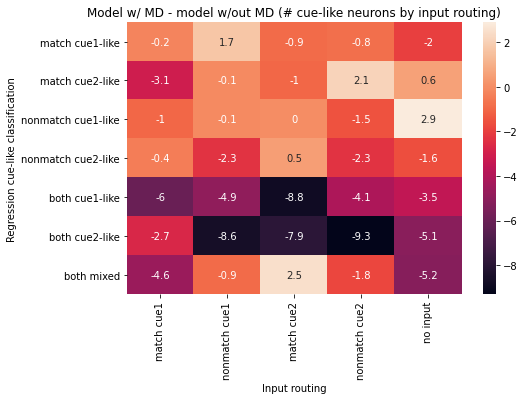

In [52]:
def count_groups(X):
    Y = []
    for arr in X:
        d = [0, 0, 0, 0, 0]
        for neuron_idx in arr:
            if neuron_idx < 100:
                d[0] = d[0] + 1
            elif neuron_idx < 200:
                d[1] = d[1] + 1
            elif neuron_idx < 300:
                d[2] = d[2] + 1
            elif neuron_idx < 400:
                d[3] = d[3] + 1
            elif neuron_idx < 500:
                d[4] = d[4] + 1
        Y.append(d)
    return Y

def comp_diff(a,b):
    A = np.matrix(count_groups(a))
    B = np.matrix(count_groups(b))
    return np.subtract(A,B).tolist()
    
D = {}
D["match cue1"] = comp_diff(match_cue1_neurons, match_cue1_neurons_noMD)
D["match cue2"] = comp_diff(match_cue2_neurons, match_cue2_neurons_noMD)
D["nonmatch cue1"] = comp_diff(nonmatch_cue1_neurons, nonmatch_cue1_neurons_noMD)
D["nonmatch cue2"] = comp_diff(nonmatch_cue2_neurons, nonmatch_cue2_neurons_noMD)
D["both cue1"] = comp_diff(cuelike_cue1_neurons, cuelike_cue1_neurons_noMD)
D["both cue2"] = comp_diff(cuelike_cue2_neurons, cuelike_cue2_neurons_noMD)
D["both mixed"] = comp_diff(cuelike_mixed_neurons, cuelike_mixed_neurons_noMD)

Ms = []
for i in range(len(D["match cue1"])):
    M = [D["match cue1"][i], 
         D["match cue2"][i],
         D["nonmatch cue1"][i],
         D["nonmatch cue2"][i],
         D["both cue1"][i],
         D["both cue2"][i],
         D["both mixed"][i]]
    Ms.append(M)

F = np.zeros((len(Ms[0]), len(Ms[0][0])))
    
for r in range(len(Ms[0])):
    for c in range(len(Ms[0][0])):
        s = 0
        for idx in range(len(D["match cue1"])):
            s = s + Ms[idx][r][c]
        F[r,c] = s / len(D["match cue1"])
        
        
cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'nonmatch cue1', 'match cue2', 'nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("Model w/ MD - model w/out MD (# cue-like neurons by input routing)")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

<ipython-input-25-f1dfce12a37f>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  print(np.array(match_cue1_neurons).shape)


(10,)
[[ 5 10  7  3  6]
 [ 3  2  7  8  4]
 [ 1  2  0  0  3]
 [ 1  1  0  0  1]
 [ 3  1  2  4  0]
 [ 3  0  6  8  2]
 [ 6  5  9  3  3]]
[5, 3, 1, 1, 3, 3, 6]
[10, 2, 2, 1, 1, 0, 5]


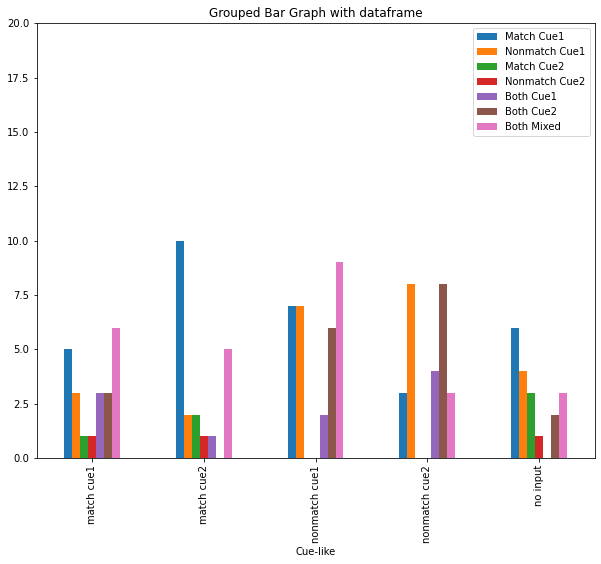

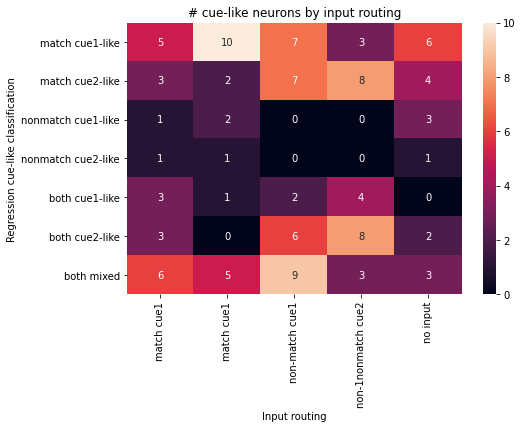

In [25]:
import pandas as pd
from operator import add

print(np.array(match_cue1_neurons).shape)

def get_plot_group(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 8
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_group_noMD(neuron_idx):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    run_num = 2    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group(neuron_idx)
        D = list(map(add, D, group))
    return D

def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for neuron_idx in range(min_neuron_idx, max_neuron_idx):
        group = get_plot_group_noMD(neuron_idx)
        D = list(map(add, D, group))
    return D
  
    
D_0_100 = ["match cue1"] + get_plot_data(0,100)
D_100_200 = ["match cue2"] + get_plot_data(100,200)
D_200_300 = ["nonmatch cue1"] + get_plot_data(200,300)
D_300_400 = ["nonmatch cue2"] + get_plot_data(300,400)
D_400_500 = ["no input"] + get_plot_data(400,500)

# D_0_100 = ["match cue1"] + get_plot_data_noMD(0,100)
# D_100_200 = ["match cue2"] + get_plot_data_noMD(100,200)
# D_200_300 = ["nonmatch cue1"] + get_plot_data_noMD(200,300)
# D_300_400 = ["nonmatch cue2"] + get_plot_data_noMD(300,400)
# D_400_500 = ["no input"] + get_plot_data_noMD(400,500)

df = pd.DataFrame([D_0_100, D_100_200, D_200_300, D_300_400, D_400_500],
                  columns=['Cue-like', 'Match Cue1', 'Nonmatch Cue1', 'Match Cue2', 'Nonmatch Cue2', 'Both Cue1', 'Both Cue2', 'Both Mixed'])
df.plot(figsize=(10,8),
        x='Cue-like',
        kind='bar',
        stacked=False,
        title='Grouped Bar Graph with dataframe',
        ylim=(0,20))

D_match_cue1 = get_plot_data(0,100)
D_match_cue2 = get_plot_data(100,200)
D_nonmatch_cue1 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_match_cue2, D_nonmatch_cue1, D_nonmatch_cue2, D_noinput]))

print(F)
print(D_match_cue1)
print(D_match_cue2)

cm_df = pd.DataFrame(np.array(F),
                     columns = ['match cue1', 'match cue1', 'non-match cue1', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'match cue2-like', 'nonmatch cue1-like', 'nonmatch cue2-like', 'both cue1-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

In [27]:
# Produce difference matrix plot (take mean over each initalization)

1

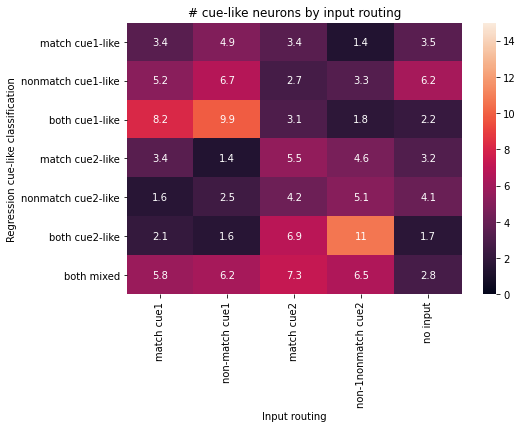

In [17]:
## THESE ARE THE GOOD 2D HIST PLOTS!


import pandas as pd
from operator import add

def get_plot_group(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons[run_num].tolist().count(neuron_idx)
        
    return R

def get_plot_data(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data(0,100)
D_nonmatch_cue1 = get_plot_data(100,200)
D_match_cue2 = get_plot_data(200,300)
D_nonmatch_cue2 = get_plot_data(300,400)
D_noinput = get_plot_data(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()


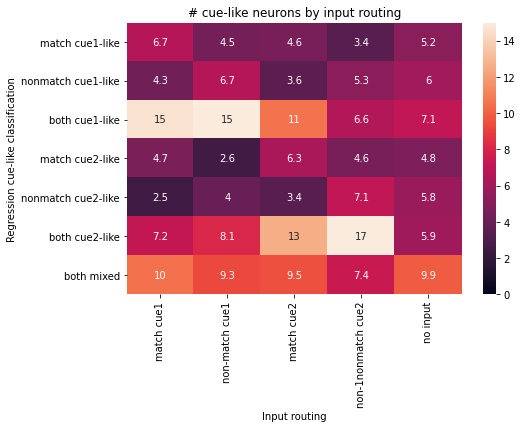

In [18]:
import pandas as pd
from operator import add

def get_plot_group_noMD(neuron_idx, run_num):
    R = [0, 0, 0, 0, 0, 0, 0]
    
    R[0] = match_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[1] = nonmatch_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[2] = cuelike_cue1_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[3] = match_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[4] = nonmatch_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[5] = cuelike_cue2_neurons_noMD[run_num].tolist().count(neuron_idx)
    R[6] = cuelike_mixed_neurons_noMD[run_num].tolist().count(neuron_idx)
        
    return R


def get_plot_data_noMD(min_neuron_idx, max_neuron_idx):
    D = [0, 0, 0, 0, 0, 0, 0]
    for run_num in range(10):
        for neuron_idx in range(min_neuron_idx, max_neuron_idx):
            group = get_plot_group_noMD(neuron_idx, run_num)
            D = list(map(add, D, [x/10 for x in group]))
    return D

D_match_cue1 = get_plot_data_noMD(0,100)
D_nonmatch_cue1 = get_plot_data_noMD(100,200)
D_match_cue2 = get_plot_data_noMD(200,300)
D_nonmatch_cue2 = get_plot_data_noMD(300,400)
D_noinput = get_plot_data_noMD(400,500)
F = np.transpose(np.array([D_match_cue1, D_nonmatch_cue1, D_match_cue2, D_nonmatch_cue2, D_noinput]))

cm_df = pd.DataFrame(F,
                     columns = ['match cue1', 'non-match cue1', 'match cue2', 'non-1nonmatch cue2', 'no input'], 
                     index = ['match cue1-like', 'nonmatch cue1-like', 'both cue1-like', 'match cue2-like', 'nonmatch cue2-like', 'both cue2-like', 'both mixed'])
plt.figure(figsize=(7.5,5))
sns.heatmap(cm_df, annot=True, vmin=0, vmax=15)
plt.title("# cue-like neurons by input routing")
plt.ylabel("Regression cue-like classification")
plt.xlabel("Input routing")
plt.show()

